# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [93]:
import pandas as pd

### Данные


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [94]:
CANCER_DATA_PATH = './hw_knn_data/cancer.csv'

In [95]:
def read_cancer_dataset(path_to_csv):
    data = pd.read_csv(path_to_csv)
    return data.drop('label', axis = 1), pd.factorize(data['label'])[0]

In [96]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [97]:
def train_test_split(X, y, ratio):
    count = int(X.shape[0] * ratio)
    return X[ :count], y[:count], X[count:], y[count:]

### Метрики

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [98]:
def get_precision_recall_accuracy(y_pred, y_true):
    precision = []
    recall = []
    accuracy = []
    classes = np.unique(y_true)
    for cls in classes:
        TP = 0
        TN = 0
        FN = 0
        FP = 0
        for true, predicted in zip(y_true, y_pred):
            if predicted == true and predicted == cls:
                TP += 1
            if true != cls and predicted != cls:
                TN += 1
            if true == cls and predicted != cls:
                FN += 1
            if true != cls and predicted == cls:
                FP += 1
        precision.append(TP/(TP + FP))
        recall.append(TP/(TP + FN))
        accuracy.append((TP + TN) /(TP + FP + TN + FN))

    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [99]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [100]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

## KNN
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [101]:
from sklearn.neighbors import KDTree

class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size

    def fit(self, X, y):
        self.X_train = X.copy()
        self.X_train['label'] = y
        self.classes = np.unique(y)
        self.tree = KDTree(X, self.leaf_size)

    def predict_proba(self, X):
        prob = np.zeros((X.shape[0], len(self.classes)))

        indexes = self.tree.query(X, self.n_neighbors, return_distance=False)

        for i, row in enumerate(indexes):
            for ind in row:
                for j, cls in enumerate(self.classes):
                    if self.X_train.iloc[ind]['label'] == cls:
                        prob[i][j] += 1

                for j in range(len(prob[i])):
                    prob[i][j] /= self.n_neighbors
        return prob

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на датасете _cancer_

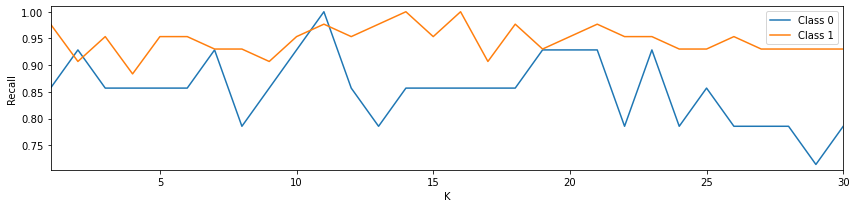

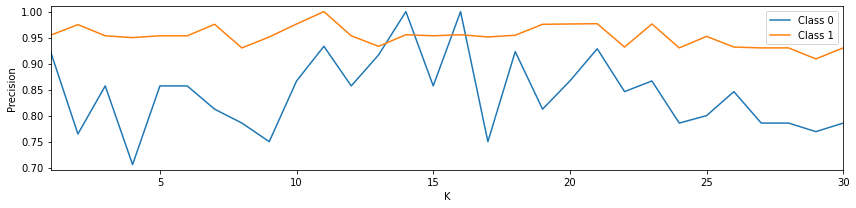

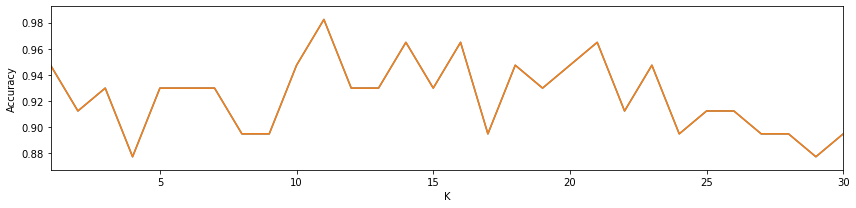

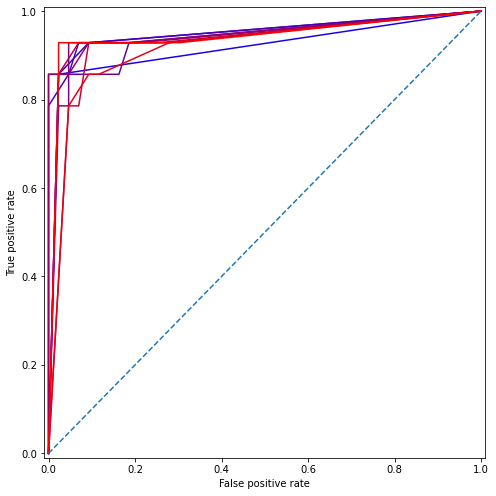

In [102]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

_Ваш ответ_

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [103]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import random
import matplotlib.pyplot as plt

In [104]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

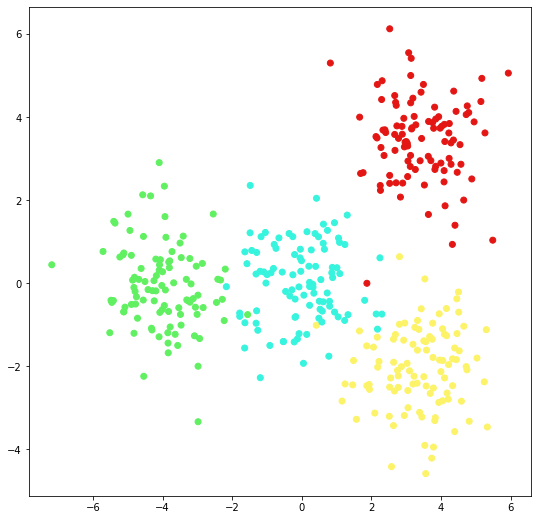

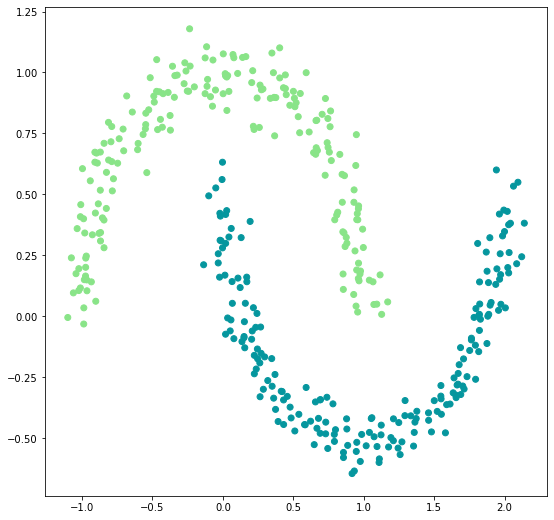

In [105]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### K-means (3 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [106]:
import math


class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters=n_clusters
        self.init=init
        self.max_iter=max_iter
        self.centroids=None
        self.clusters = [[] for _ in range(n_clusters)]
        
    def fit(self, X, y=None):
        if self.init=="random":
            self.centroids = [X[i] for i in random.sample(range(self.n_clusters), self.n_clusters)]
        if self.init=="sample":
            self.centroids = [X[i] for i in random.choice(np.indices(X), self.n_clusters)]
        if self.init=="k-means++":
            self.centroids = [random.choice(X)]
            while len(self.centroids) < self.n_clusters:
                dist=np.empty(len(X))
                for i, x in enumerate(X):
                    dist[i] = min([math.sqrt(sum((x - centr) ** 2)) for centr in self.centroids])**2
                prob=dist/sum(dist)
                r_ind = np.random.choice(X.shape[0], 1, p=prob)[0]
                self.centroids.append(X[r_ind])

        for _ in range(self.max_iter):
            for x_ind, x in enumerate(X):
                for cl_ind, cluster in enumerate(self.clusters):
                    if x_ind in cluster:
                        self.clusters[cl_ind].remove(x_ind)
                        break
                closest_index = None
                closest_distance = None
                for c_ind, centr in enumerate(self.centroids):
                    dist = math.sqrt(sum((x - centr) ** 2))
                    if closest_index is None or dist < closest_distance:
                        closest_index = c_ind
                        closest_distance = dist
                closest =  closest_index
                self.clusters[closest].append(x_ind)
            self.centroids = [[np.mean(np.take(X[:, i], cluster)) for i in range(np.prod(X.shape[1:]))] for cluster in self.clusters]

    def predict(self, X):
        result = np.zeros(len(X), dtype=np.int32)

        for x_ind, x in enumerate(X):
            min_dist = math.sqrt(sum((x - self.centroids[0]) ** 2))

            for c_ind, centr in enumerate(self.centroids):
                dist = math.sqrt(sum((x - centr) ** 2))
                if dist < min_dist:
                    min_dist = dist
                    result[x_ind] = c_ind

        return result

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

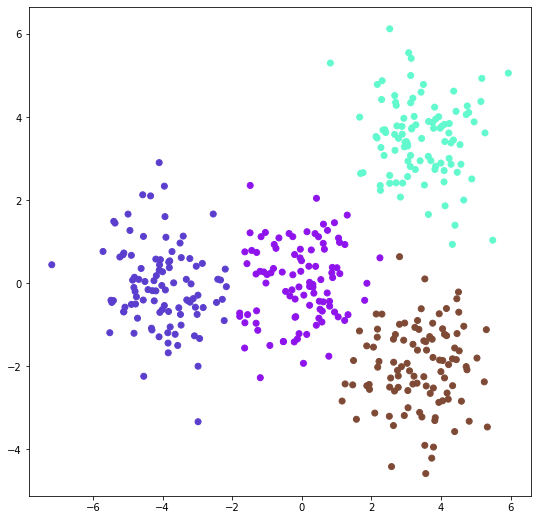

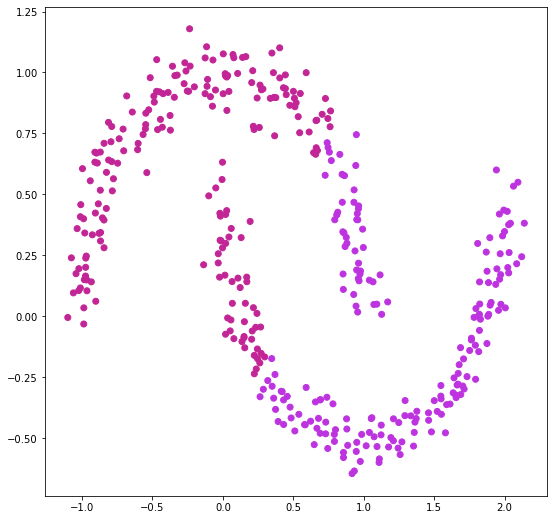

In [107]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
X1_k_means_labels = kmeans.predict(X_1)
visualize_clasters(X_1, X1_k_means_labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
X2_k_means_labels = kmeans.predict(X_2)
visualize_clasters(X_2, X2_k_means_labels)

### DBScan (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [108]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps=eps
        self.min_samples=min_samples
        self.leaf_size=leaf_size
        self.metric=metric

    def fit_predict(self, X, y=None):
        self.tree = KDTree(X, self.leaf_size, self.metric)
        cluster_count=0
        noise=-1
        # None <=> not visited
        label = [None for _ in range(len(X))]
        for x_ind, x in enumerate(X):
            if label[x_ind] is not None:
                continue

            neighbours = self.tree.query_radius([x], self.eps)[0]
            if len(neighbours) < self.min_samples:
                label[x_ind] = noise
            else:
                label[x_ind] = cluster_count
                for q in neighbours:
                    if label[q] is None or label[q]==noise:
                        label[q] = cluster_count
                        q_neighbours = self.tree.query_radius([X[q]], self.eps)[0]
                        if len(q_neighbours) >= self.min_samples:
                            np.concatenate((neighbours, q_neighbours))
                cluster_count += 1

        result = np.zeros(len(X), dtype=int)
        for ind, lab in enumerate(label):
            if lab is not None and lab != noise:
                result[ind] = lab

        return result

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

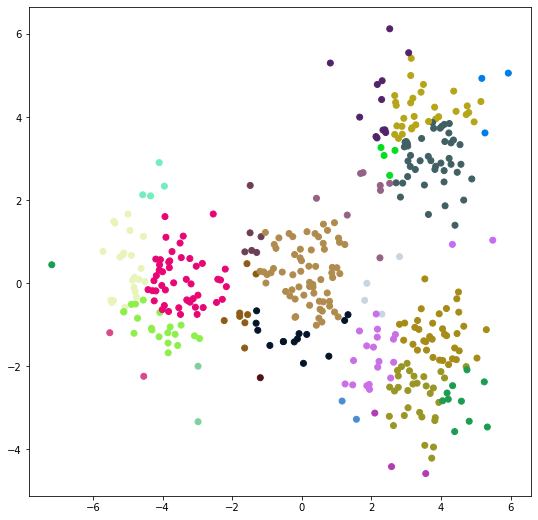

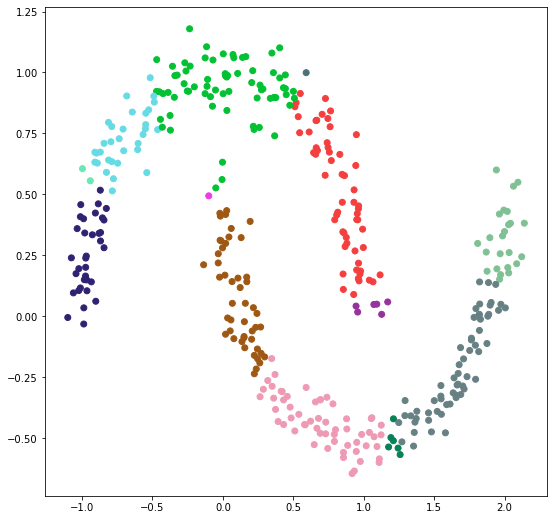

In [109]:
dbscan = DBScan(eps=1.5)
X1_labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, X1_labels)

dbscan = DBScan()
X2_labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, X2_labels)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

davies_bouldin_score: маленькие, минимум 0
silhouette_score: лучшее значение 1, худшее -1

In [110]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [111]:
print("DBScan")
print("davies_bouldin_score")
print(davies_bouldin_score(X_1, X1_labels))
print(davies_bouldin_score(X_2, X2_labels))

print("silhouette_score")
print(silhouette_score(X_1, X1_labels))
print(silhouette_score(X_2, X2_labels))
print("KMeans")
print("davies_bouldin_score")
print(davies_bouldin_score(X_1, X1_k_means_labels))
print(davies_bouldin_score(X_2, X2_k_means_labels))
print("silhouette_score")
print(silhouette_score(X_1, X1_k_means_labels))
print(silhouette_score(X_2, X2_k_means_labels))

DBScan
davies_bouldin_score
1.8275703692983396
0.6013418526183865
silhouette_score
0.14188788140978514
0.14417790566225197
KMeans
davies_bouldin_score
0.5736890100498866
0.7795336683404461
silhouette_score
0.5735668326294514
0.4881046618834058
